In [588]:
import numpy as np
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import scipy.misc
import imageio
import itertools

## Functions

In [742]:
def generate_perlin_noise_2d(shape, res):
    def f(t):
        return 6*t**5 - 15*t**4 + 10*t**3
    
    delta = (res[0] / shape[0], res[1] / shape[1])
    d = (shape[0] // res[0], shape[1] // res[1])
    grid = np.mgrid[0:res[0]:delta[0],0:res[1]:delta[1]].transpose(1, 2, 0) % 1
    # Gradients
    angles = 2*np.pi*np.random.rand(res[0]+1, res[1]+1)
    gradients = np.dstack((np.cos(angles), np.sin(angles)))
    g00 = gradients[0:-1,0:-1].repeat(d[0], 0).repeat(d[1], 1)
    g10 = gradients[1:  ,0:-1].repeat(d[0], 0).repeat(d[1], 1)
    g01 = gradients[0:-1,1:  ].repeat(d[0], 0).repeat(d[1], 1)
    g11 = gradients[1:  ,1:  ].repeat(d[0], 0).repeat(d[1], 1)
    # Ramps
    n00 = np.sum(np.dstack((grid[:,:,0]  , grid[:,:,1]  )) * g00, 2)
    n10 = np.sum(np.dstack((grid[:,:,0]-1, grid[:,:,1]  )) * g10, 2)
    n01 = np.sum(np.dstack((grid[:,:,0]  , grid[:,:,1]-1)) * g01, 2)
    n11 = np.sum(np.dstack((grid[:,:,0]-1, grid[:,:,1]-1)) * g11, 2)
    # Interpolation
    t = f(grid)
    n0 = n00*(1-t[:,:,0]) + t[:,:,0]*n10
    n1 = n01*(1-t[:,:,0]) + t[:,:,0]*n11
    return np.sqrt(2)*((1-t[:,:,1])*n0 + t[:,:,1]*n1)
        
def generate_fractal_noise_2d(shape, res, octaves=1, persistence=0.5):
    noise = np.zeros(shape)
    frequency = 1
    amplitude = 1
    for _ in range(octaves):
        noise += amplitude * generate_perlin_noise_2d(shape, (frequency*res[0], frequency*res[1]))
        frequency *= 2
        amplitude *= persistence
    return noise



def fractal_generator(persistence):
    perlin = generate_fractal_noise_2d((256,256), (2,2), octaves=8, persistence=persistence)
    #perlin = (perlin)/np.max(np.max(abs(perlin)))
    #for i in range(len(perlin)):
    #    for j in range(len(perlin)):
    #        if perlin[i][j] >= 0:
    #            perlin[i][j] = 1
    #        elif perlin[i][j] < 0:
    #            perlin[i][j] = -1
    return perlin

def increments (steps, direction = 0):
    steps = int(100/steps)
    a = range(0,100,steps)
    b = [x for x in a]
    
    if direction == 1:
        c = b + [100]
        b.reverse()
        d = c + b
    else:
        c = b
        d = c
    e = [x/100 for x in d]
    return e

def Interpol(imageA, imageB, steps, direction = 0):
    inter_matrix = []
    steps = increments(steps, direction)
    imageA = Image.fromarray(imageA).convert('L') 
    imageB = Image.fromarray(imageB).convert('L') 
    for k in steps:
        PIL.Image.blend(imageA, imageB, k)
        outImage = np.asarray(imageA) * (1.0 - k) + np.asarray(imageB) * k
        inter_matrix.append(outImage)
        #final_matrix = np.array(inter_matrix).T
    return inter_matrix

def contrast(image):    
    for i in range(len(image)):
        for j in range(len(image)):
            if image[i][j] >= 0:
                image[i][j] = 1
            elif image[i][j] < 0:
                image[i][j] = -1
    return image

def InterpolMulti(size, list_image, steps):
    size = 256
    InterpolTemp = np.empty((0, size, size))

    for first, second in zip(list_image, list_image[1:]):
        InterpolMatrix = Interpol(first, second, steps)
        InterpolMatrix = np.array(InterpolMatrix)
        InterpolTemp = np.vstack((InterpolTemp, InterpolMatrix))
    InterpolMulti = np.array(InterpolTemp)
    return InterpolMulti

In [739]:
list_persistence = [0.1, 0.2, 0.3, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90]
list_temp = []
for x in list_persistence:
    image = contrast(fractal_generator(x))
    list_temp.append(image)
list_image = np.array(list_temp)

In [743]:
Interpol = InterpolMulti(256, list_image, 20)

In [744]:
Interpol.shape

(280, 256, 256)

In [574]:

#image1 = 2.*(image1 - np.min(image1))/np.ptp(image1)-1
#image2 = 2.*(image2 - np.min(image2))/np.ptp(image2)-1
#InterpolMatrix = Interpol(image1, image2, 10, 1)

In [504]:
# Recale between 0 and 1
image1 = (image1 - np.min(image1))/np.ptp(image1)
image2 = (image2 - np.min(image2))/np.ptp(image2)

# Rescale between -1 and 1
image1 = 2.*(image1 - np.min(image1))/np.ptp(image1)-1
image2 = 2.*(image2 - np.min(image2))/np.ptp(image2)-1

InterpolMatrix = Interpol(image1, image2, 10)

0.7

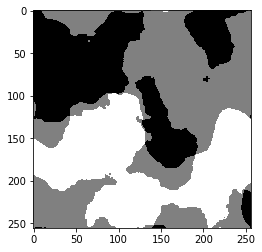

In [748]:
plt.imshow(Interpol[70], cmap='gray')